In [1]:
import pytesseract

import matplotlib.pyplot as plt

import numpy as np

import cv2

from copy import deepcopy

from PIL import Image

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [3]:
def preprocess(img) :
    
    plt.title(' Image')
    
    plt.imshow(img)
    
    plt.show()
    
    imgBlurred = cv2.GaussianBlur(img, (5,5), 0)
    
    gray = cv2.cvtColor(imgBlurred, cv2.COLOR_BGR2GRAY)

    sobelx = cv2.Sobel(gray,cv2.CV_8U,1,0,ksize=3)
    
    plt.title(' Sobel Image ')
    
    plt.imshow(sobelx)
    
    plt.show()
    
    ret2 , threshold_img = cv2.threshold(sobelx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    plt.title(' Threshold Image ')
    
    plt.imshow(threshold_img)
    
    plt.show()
    
    return threshold_img

def cleanPlate(plate) :
    
    gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    
    thresh = cv2.dilate(gray, kernel, iterations = 1)

    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    
    contours, hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if contours :
        
        areas = [cv2.contourArea(c) for c in contours]
        
        max_index = np.argmax(areas)

        max_cnt = contours[max_index]
        
        max_cntArea = areas[max_index]
        
        x,y,w,h = cv2.boundingRect(max_cnt)

        if not ratioCheck(max_cntArea,w,h) :
            
            return plate, None

        cleaned_final = thresh[y : y + h, x : x + w]
        
        plt.title(' Cleaned Final ')
        
        plt.imshow(cleaned_final)
        
        plt.show()
        
        return cleaned_final,[x,y,w,h]

    else :
        
        return plate, None

def extract_contours(threshold_img) :
    
    element = cv2.getStructuringElement(shape = cv2.MORPH_RECT, ksize = (17, 3))
    
    morph_img_threshold = threshold_img.copy()
    
    cv2.morphologyEx(src=threshold_img, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
    
    plt.title(' Morphed')
    
    plt.imshow(morph_img_threshold)
    
    plt.show()

    contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
    
    return contours


def ratioCheck(area, width, height) :
    
    ratio = float(width) / float(height)
    
    if ratio < 1 :
        
        ratio = 1 / ratio

    aspect = 4.7272
    
    min = 15 * aspect * 15
    
    max = 125 *aspect * 125

    rmin = 3
    
    rmax = 6

    if (area < min or area > max) or (ratio < rmin or ratio > rmax) :
        
        return False
    
    return True

def isMaxWhite(plate) :
    
    
    avg = np.mean(plate)
    
    if(avg >= 115) :
        
        return True
    
    else :
        
        return False

def validateRotationAndRatio(rect) :
    
    (x, y), (width, height), rect_angle = rect

    if(width>height) :
        
        angle = -rect_angle
        
    else :
        
        angle = 90 + rect_angle

    if angle>15 :
        
        return False

    if height == 0 or width == 0 :
        
        return False

    area = height*width
    
    if not ratioCheck(area,width,height) :
        
        return False
    
    else :
        
        return True

def cleanAndRead(img,contours) :
    
    for i,cnt in enumerate(contours) :
        
        min_rect = cv2.minAreaRect(cnt)

        if validateRotationAndRatio(min_rect) :
            
            x,y,w,h = cv2.boundingRect(cnt)
            
            plate_img = img[y : y + h, x : x + w]

            if(isMaxWhite(plate_img)) :
                
                clean_plate, rect = cleanPlate(plate_img)
                
                if rect :
                    
                    x1,y1,w1,h1 = rect
                    
                    x,y,w,h = x + x1 , y + y1, w1, h1
                    
                    plt.title(' Cleaned Plate ')
                    
                    plt.imshow(clean_plate)
                    
                    plate_im = Image.fromarray(clean_plate)
                    
                    text = pytesseract.image_to_string(plate_im, lang='eng')
                    
                    print(" Detected Text : ", text)
                    
                    img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
                    
                    plt.title(' Detetected Plate ')
                    
                    plt.imshow(img)
                    
                    plt.show()

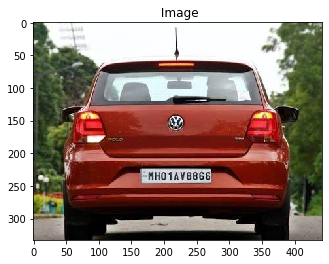

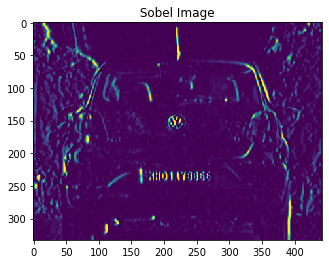

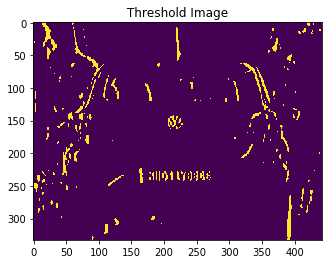

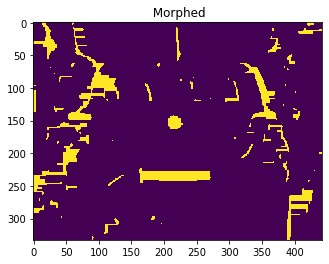

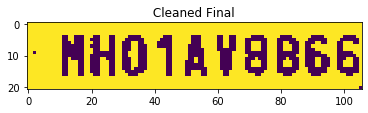

 Detected Text :  NHO1AYSBEE



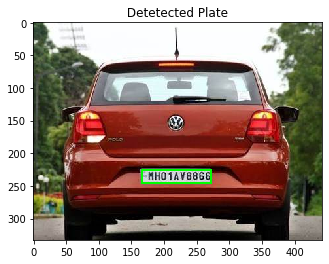

In [4]:
img = cv2.imread('./Images/Car.jpg')

img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

threshold_img = preprocess(img)

contours = extract_contours(threshold_img)

cleanAndRead(img , contours)